# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to a close number with a defined precision.

## Guessing...

In [1]:
import struct
import numpy as np
import pandas as pd
import random
from pprint import pprint

from guess_range import *

In [2]:
def generate_known_inputs(exps=(-1, 3), nsize=3000):
    low, high = exps[0], (exps[1] + 1)
    subsize = int(nsize / (high - low))
    return pd.DataFrame(
        data=[np.random.uniform(-10.0 ** i, 10.0 ** i, subsize) for i in range(low, high)],
        index=range(low, high))

In [3]:
def guess_number_range_stat(secret_number, guess_range, prescision, known_input_size=3000):
    known_input_set = generate_known_inputs(exps=(-1, 3), nsize=known_input_size)
    results = guess_number_range_multiple_inputs(secret_number, guess_range, prescision, known_input_set)
    # pprint(results)
    #
    # discard low correlation results
    corr_values = results[CORRELATION]
    results = results[corr_values > (corr_values.max() * 0.95)].sort_values(CORRELATION, ascending=False)
    guess_values = ((results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0).round(decimals=int(-np.log10(prescision)))
    return results[~guess_values.duplicated(keep='first')]

In [4]:
SECRET_VALUE = 'secret value'

guess_range = (-5e0, 5.0e0)
prescision = 1e-7
#
# initalize parameter and generate a random number (secret number)
known_input_size = 10000

## Test single point

In [5]:
secret_number = random.uniform(guess_range[0] / 10, guess_range[1] / 10) 

In [6]:
%%time
single_results = guess_number_range_stat(secret_number, guess_range, prescision, known_input_size)
print(secret_number)
single_results

-0.45024397022219753
CPU times: user 1min 2s, sys: 1.87 s, total: 1min 4s
Wall time: 1min 4s


,low value,high value,correlation
-1,-0.450244,-0.450244,0.999826


In [7]:
guess_values = (single_results[LOW_VALUE] + single_results[HIGH_VALUE]) / 2.0
error_rates = ((guess_values - secret_number) / secret_number).abs() * 100.0
pprint(error_rates)
guessed_number = guess_values[error_rates.idxmin()]    
pprint('the secret number = %f' % secret_number)
pprint('the guessed number = %f' % guessed_number)
pprint('best correlation = %f' % single_results[CORRELATION][error_rates.idxmin()])
pprint('error rate = %0.6f%s' % (error_rates.min(), '%'))

-1    0.000004
dtype: float64
'the secret number = -0.450244'
'the guessed number = -0.450244'
'best correlation = 0.999826'
'error rate = 0.000004%'


## Test multiple points

In [8]:
multiple_results = pd.DataFrame()

In [9]:
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (100,)


In [10]:
%%time
loops = 0
for idx in secret_numbers:
    # if the number is already treated, the ignore it
    if (SECRET_VALUE in multiple_results.columns) and (idx in multiple_results[SECRET_VALUE].values):
        continue    
    results = guess_number_range_stat(idx, guess_range, prescision, known_input_size)
    results[SECRET_VALUE] = idx
    pprint('=' * 20)
    pprint(results)
    guess_values = (results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0
    multiple_results = pd.concat([multiple_results, results], axis=0, ignore_index=True)
    loops = loops + 1

'===================='
   low value  high value  correlation  secret value
0  -3.284259   -3.284259          1.0     -3.284259
'===================='
   low value  high value  correlation  secret value
2   2.387437    2.387437          1.0      2.387437
'===================='
   low value  high value  correlation  secret value
3  -0.687093   -0.687092          1.0     -0.687092
'===================='
   low value  high value  correlation  secret value
1  -0.472725   -0.472725     0.999906     -0.472725
0  -1.890900   -1.890900     0.985141     -0.472725
'===================='
   low value  high value  correlation  secret value
1  -0.236893   -0.236893     0.883153     -0.236893
'===================='
    low value  high value  correlation  secret value
 3  -0.777049   -0.777049     0.999966     -0.777049
-1  -3.108195   -3.108195     0.972162     -0.777049
'===================='
    low value  high value  correlation  secret value
-1   3.837977    3.837977          1.0      3.837977
'=

'===================='
    low value  high value  correlation  secret value
 1  -1.096423   -1.096423     1.000000     -1.096423
-1  -4.385691   -4.385691     0.978161     -1.096423
'===================='
   low value  high value  correlation  secret value
2  -0.378253   -0.378253     0.999965     -0.378253
0  -1.513014   -1.513014     0.980562     -0.378253
'===================='
    low value  high value  correlation  secret value
 2  -0.076697   -0.076696     0.998311     -0.076697
-1  -1.227144   -1.227144     0.992716     -0.076697
'===================='
   low value  high value  correlation  secret value
1   0.352845    0.352845     0.998764      0.352845
0   1.411380    1.411380     0.979347      0.352845
'===================='
    low value  high value  correlation  secret value
-1  -4.248722   -4.248722          1.0     -4.248722
'===================='
   low value  high value  correlation  secret value
0  -4.816189   -4.816189          1.0     -4.816189
'===================='

### Save data

In [11]:
from datetime import datetime
multiple_results_fname = 'multiple_results-%s.csv' % datetime.now().strftime("%Y%m%d_%H%M%S")
multiple_results.to_csv(multiple_results_fname)
pprint('multiple_results_fname = %s' % multiple_results_fname)

'multiple_results_fname = multiple_results-20200523_011136.csv'


### Load data

In [28]:
# multiple_results_fname = 'multiple_results-20200523_011136.csv'
multiple_results = pd.read_csv(multiple_results_fname, index_col=0)
multiple_results

,low value,high value,correlation,secret value
0,-3.284259,-3.284259,1.000000,-3.284259
1,2.387437,2.387437,1.000000,2.387437
2,-0.687093,-0.687092,1.000000,-0.687092
3,-0.472725,-0.472725,0.999906,-0.472725
4,-1.890900,-1.890900,0.985141,-0.472725
...,...,...,...,...
149,-4.854488,-4.854488,1.000000,-4.854488
150,-2.640574,-2.640574,1.000000,-2.640574
151,0.148523,0.148523,0.999661,0.148523
152,2.376374,2.376374,0.981078,0.148523


### Hit targets and missed targets

In [29]:
#
# compute the number of secret values which are present in guessed ranges
n_identified_ranges = multiple_results.groupby(SECRET_VALUE).apply(lambda x: ((x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE])).any())
counts = n_identified_ranges.value_counts()
if True in counts.index:
    pprint('The number of identified values: %d/%d' % (counts[True], counts.sum()))
if False in counts.index:
    pprint('The number of missed values: %d/%d' % (counts[False], counts.sum()))

'The number of identified values: 92/100'
'The number of missed values: 8/100'


### Graphs of the first choices

In [14]:
first_choice_results = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]

# the number of correct values
n_correct_values = first_choice_results.apply(lambda x: (x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE]), axis=1)
pprint(n_correct_values.value_counts())

guess_values = (first_choice_results[LOW_VALUE] + first_choice_results[HIGH_VALUE]) / 2.0
guess_values.index = first_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

True     89
False    11
dtype: int64


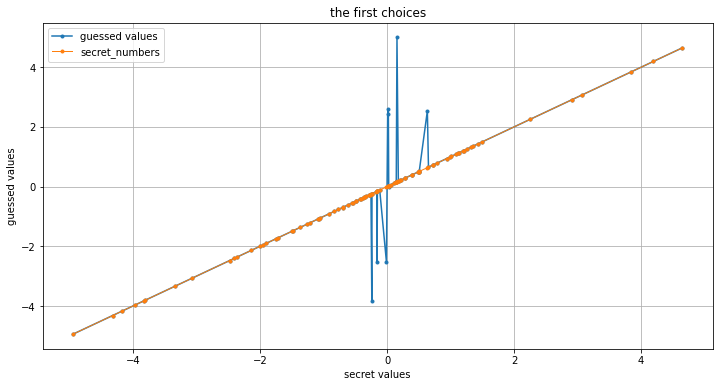

In [15]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the first choices')
ax.grid(True)

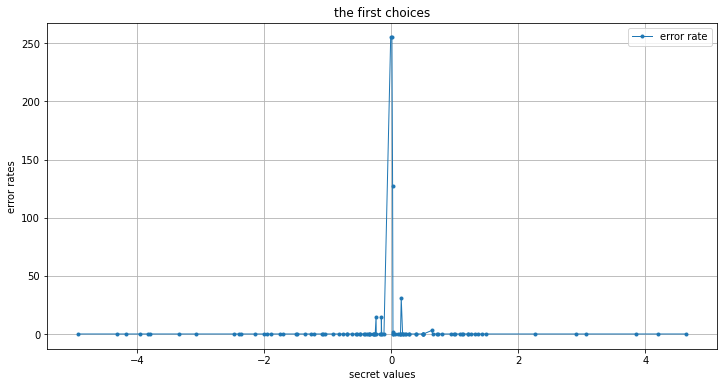

In [16]:
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the first choices')
ax.grid(True)

### Graphs of the second choice

In [17]:
pprint('The total number of the second choices is: %d' % (multiple_results.groupby(SECRET_VALUE).size().prod()-1))

'The total number of the second choices is: 17099604835172351'


In [18]:
guess_values = ((multiple_results[LOW_VALUE] + multiple_results[HIGH_VALUE]) / 2.0)
error_rate = ((guess_values - multiple_results[SECRET_VALUE])/multiple_results[SECRET_VALUE]).abs()
second_choice_results = multiple_results.loc[error_rate.groupby(multiple_results[SECRET_VALUE]).idxmin()]
guess_values = ((second_choice_results[LOW_VALUE] + second_choice_results[HIGH_VALUE]) / 2.0)
guess_values.index = second_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

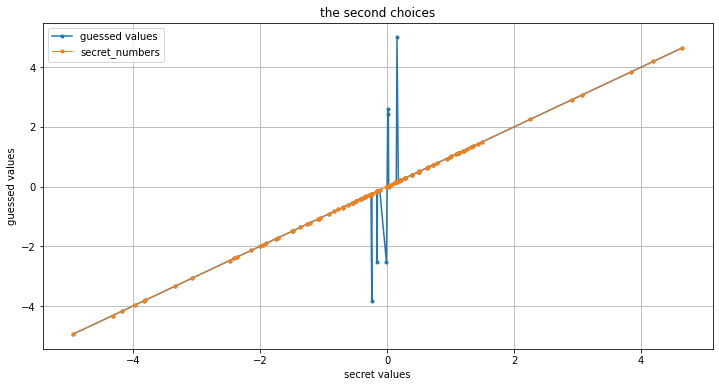

In [19]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the second choices')
ax.grid(True)

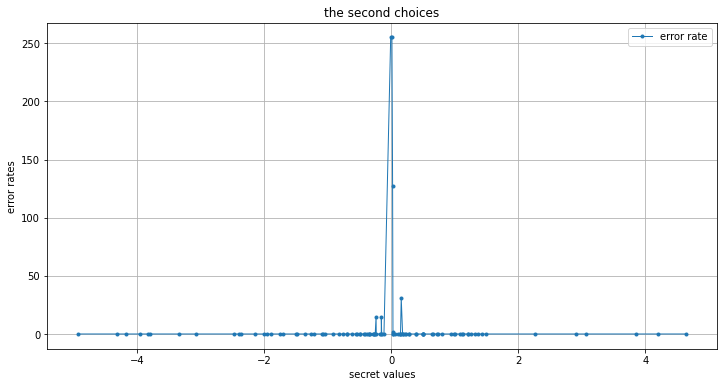

In [20]:
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the second choices')
ax.grid(True)

# Batina method

In [21]:
def batina_guess_number(secret_number, guess_range, prescision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, prescision)
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    hw['actual'] = np.vectorize(hamming_weight)(known_inputs * secret_number)
    return hw.corr(method='pearson')['actual'].drop('actual').idxmax()

In [22]:
batinta_results = pd.Series(name='guessed_numbers', dtype=np.float32)
# we have to define a low precision, otherwise, it takes too long time to run
prescision = 1e-3
known_inputs = np.random.uniform(-1e1, 1e1, known_input_size)

In [23]:
%%time
for idx in secret_numbers:
    if idx in batinta_results.index:
        continue    
    batinta_results[idx] = batina_guess_number(idx, guess_range, prescision, known_inputs)
    print('secret_value = %f, guessed_value = %f' % (idx, batinta_results[idx]))
batinta_results.sort_index(inplace=True)    

secret_value = -3.284259, guessed_value = -3.284000
secret_value = 2.387437, guessed_value = 2.387000
secret_value = -0.687092, guessed_value = -0.687000
secret_value = -0.472725, guessed_value = -0.473000
secret_value = -0.236893, guessed_value = -0.237000
secret_value = -0.777049, guessed_value = -0.777000
secret_value = 3.837977, guessed_value = 3.838000
secret_value = 1.483277, guessed_value = 1.483000
secret_value = -3.125446, guessed_value = -3.125000
secret_value = -3.679204, guessed_value = -3.679000
secret_value = 4.211309, guessed_value = 4.211000
secret_value = -0.228436, guessed_value = -0.228000
secret_value = -4.593031, guessed_value = -4.593000
secret_value = 4.449552, guessed_value = 4.450000
secret_value = 0.843877, guessed_value = 0.844000
secret_value = 1.192912, guessed_value = 1.193000
secret_value = 1.100039, guessed_value = 1.100000
secret_value = 0.332456, guessed_value = 0.333000
secret_value = 3.216816, guessed_value = 3.217000
secret_value = -0.285279, guesse

KeyboardInterrupt: 

### Save data

In [30]:
from datetime import datetime
batinta_results_fname = 'batinta_results-%s.csv' % datetime.now().strftime("%Y%m%d_%H%M%S")
batinta_results.to_csv(batinta_results_fname)
pprint('batinta_results_fname = %s' % batinta_results_fname)

'batinta_results_fname = batinta_results-20200523_152207.csv'


### Load data

In [38]:
# batinta_results_fname = 'batinta_results-%s.csv' % '20200522_071337'
batinta_results = pd.read_csv(batinta_results_fname, index_col=0, squeeze=True)
batinta_results.sort_index(inplace=True)    
batinta_results

-4.593031   -4.593
-4.074591   -4.075
-3.679204   -3.679
-3.284259   -3.284
-3.125446   -3.125
-1.455040   -1.455
-0.777049   -0.777
-0.687092   -0.687
-0.472725   -0.473
-0.430621   -0.431
-0.328540   -0.329
-0.285279   -0.285
-0.236893   -0.237
-0.228436   -0.228
-0.062795   -4.019
-0.062136   -3.977
-0.029280   -3.748
 0.162747    2.604
 0.200418    3.207
 0.214317    0.214
 0.241718    0.242
 0.278909    0.279
 0.332456    0.333
 0.843877    0.844
 0.870246    0.870
 1.100039    1.100
 1.192912    1.193
 1.483277    1.483
 2.272627    2.273
 2.387437    2.387
 3.216816    3.217
 3.837977    3.838
 3.984200    3.984
 4.211309    4.211
 4.449552    4.450
Name: guessed_numbers, dtype: float64

### Graphs

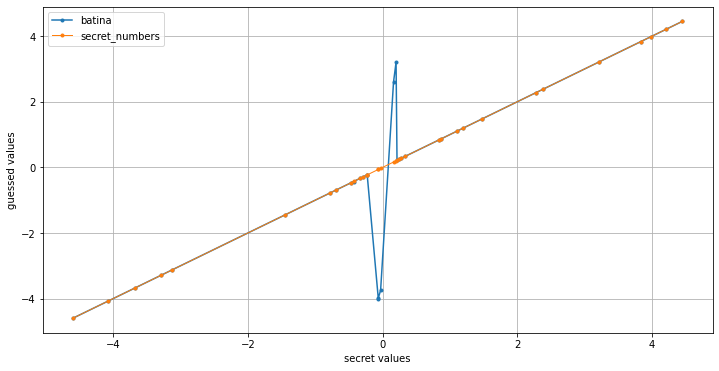

In [39]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
#results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

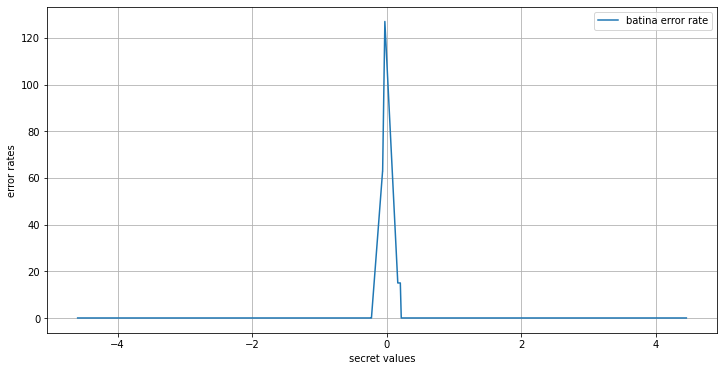

In [42]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
#ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)

In [47]:
batina_error_rate[batina_error_rate > 0.10]

-0.062795     63.001525
-0.062136     63.004641
-0.029280    127.006998
 0.162747     15.000295
 0.200418     15.001585
dtype: float64

In [50]:
(batina_error_rate < 0.10).value_counts()

True     30
False     5
dtype: int64